## Part 1: Load Libaries and Import necessary dataset

In [377]:
# https://otexts.com/fpp3/prophet.html
# Load required libraries. Make sure to install them too
library(readxl)
library(dplyr)
library(Rcpp)
library(ggplot2)
library(lubridate)
library(forecast)
library(prophet)
library(Metrics)
library(zoo) # use for date formatting 
library(stats) # use for additive
library(caret)
library(glmnet)


In [378]:
# Extract deposit_levels to use it in this file
deposit_levels <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/deposit_levels.rds") # Load the data


In [379]:
# Extract regressors_data to use it in this file
regressors_data <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/regressors_data.rds")

In [380]:
glimpse(deposit_levels)

Rows: 162
Columns: 2
$ time     <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "1985Q2", "…
$ deposits <dbl> 22917257000, 23575192000, 24308965000, 24967964000, 256737460…


## Part 2: Data Exploration for Prophet Assumption

### Step 1: Data Regularity and Sufficient Historical Data Expectation

- **Purpose**: Prophet requires data to be regular (no gaps in time periods) and free of missing values to build accurate forecasts.

In [381]:
sum(is.na(deposit_levels))  # no missing values

[1] 0

- The time series has regular quaterly intervals and no missing values so the data regurlarity expectation is satified. 

- It also has decades worth of data so the "sufficient historical data" expectation is satisfied. 

### Step 2: Presence of Trend Expectation

- **Purpose**: Prophet models require a clear understanding of the trend to accurately forecast future values. 

- **Next Steps**: Evaluate whether the data exhibits a linear or logistic trend.

- **Question** Does the choice of a linear trend or logistic trend affect Prophet's predictions?

- **Answer** : Yes, it absolutely affects the predictions. Here’s how:

    - **Linear Trend**: Assumes that growth continues indefinitely at a constant rate.
        - Future predictions will show a strong upward trend, even if the data is slowing down.
        - Example: If you fit a linear trend to deposit levels, Prophet will extrapolate a steadily increasing deposit level far into the future.

    - **Logistic Trend**: Assumes growth slows as it approaches a saturation point. 
        - Future predictions will show a more tamed upward trend, leveling off over time.
        - Example: If deposits are approaching a plateau, a logistic trend will reflect that in future predictions, ensuring the model doesn't over-predict growth.

- **Key Insight**:If you fit Prophet with the wrong trend type (e.g., linear when the data shows signs of saturation), your forecasts will misrepresent the future. Context is critical here: If you know from domain expertise or external analysis that growth will saturate, using a logistic trend will give more realistic predictions.

#### a. Formatting the time as a date instead of a character and also have anumeric format of the date

In [382]:
# Step 1: Format time as date 
# Format
time <- as.Date(as.yearqtr(deposit_levels$time, format = "%YQ%q"))
# Add the formatted date back into the dataset
deposit_levels$time_as_date <- time

# Step 2: Format time as numeric
# Format
time2 <- as.numeric(deposit_levels$time_as_date)
#  Add the formatted date back into the dataset
deposit_levels$time_as_numeric <- time2

# Check
glimpse(deposit_levels)

Rows: 162
Columns: 4
$ time            <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "198…
$ deposits        <dbl> 22917257000, 23575192000, 24308965000, 24967964000, 25…
$ time_as_date    <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-01, 1985-…
$ time_as_numeric <dbl> 5113, 5204, 5295, 5387, 5479, 5569, 5660, 5752, 5844, …


#### b. Visualizing Linear Trend

`geom_smooth()` using formula = 'y ~ x'


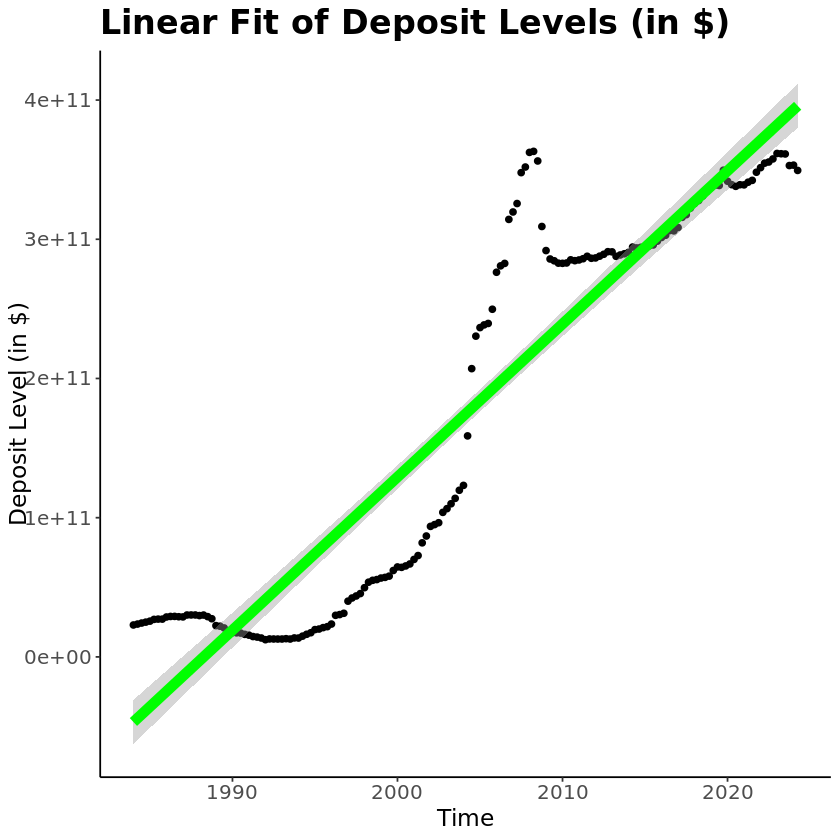

In [383]:
# Step 1: Time needs to be formatted as numeric for it to work ==> DONE above

# Step 2: Fit the linear model
linear_model <- lm(deposits ~ time_as_numeric ,data = deposit_levels) # Use time as numeric here

# Step 3: Plot the model
ggplot(deposit_levels, aes(x = time_as_date, y = deposits)) + 
  geom_point() +
  geom_smooth(method = lm, col = "green", linewidth = 3) + 
  labs(title = "Linear Fit of Deposit Levels (in $)", 
       x = "Time", 
       y = "Deposit Level (in $)") +
  theme_classic() + 
  theme(
    plot.title = element_text(size = 20, face = "bold"), # Increase title size
    axis.title.x = element_text(size = 14),             # Increase x-axis label size
    axis.title.y = element_text(size = 14),             # Increase y-axis label size
    axis.text = element_text(size = 12)                 # Increase axis tick labels size
  )

#### c. Visualizing Logistic Growth Trend

- Not the same as logistic resgression

- A mathematical model used to describe non-linear growth that slows as it approaches a saturation point.

Warning message in geom_point(color = "black", linewidth = 1):
“Ignoring unknown parameters: `linewidth`”


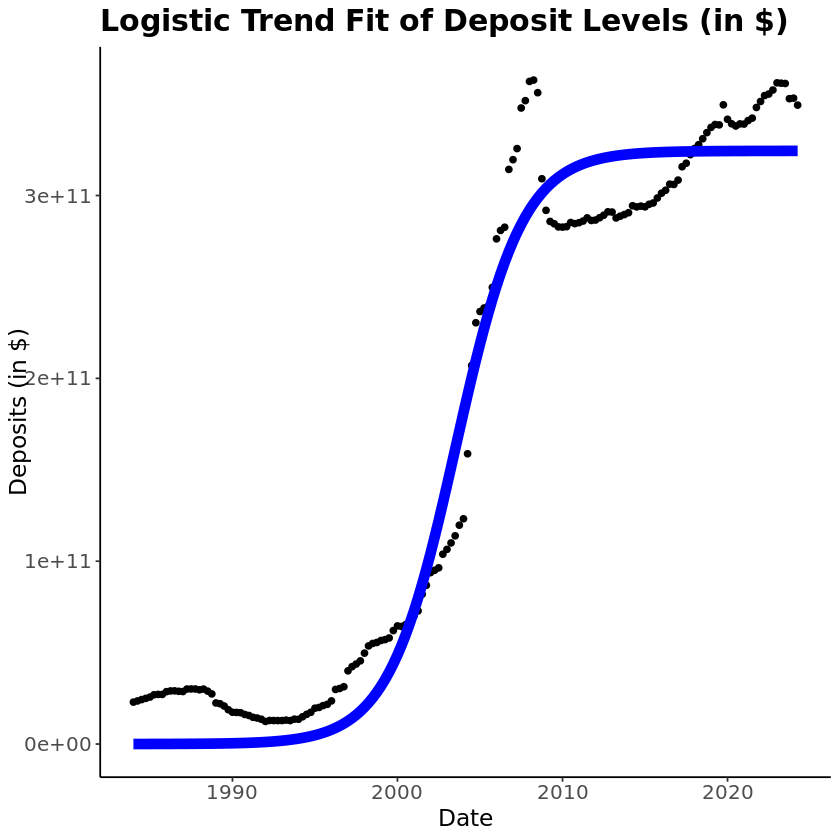

In [384]:
# Step 1: Define a logistic function
logistic_function <- function(x, L, k, x0) {
  L / (1 + exp(-k * (x - x0)))  # L = carrying capacity, k = growth rate, x0 = midpoint
}

# Step 2: Fit the logistic model
logistic_model <- nls(deposits ~ logistic_function(time_as_numeric, L, k, x0),
                      data = deposit_levels,
                      start = list(L = max(deposit_levels$deposits), k = 0.01, x0 = median(deposit_levels$time_as_numeric)))


# Step 3: Add logistic trend predictions to the dataset
deposit_levels <- deposit_levels %>%
  mutate(logistic_trend = predict(logistic_model))

# Step 4: Plot the linear model
ggplot(deposit_levels, aes(x = time_as_date, y = deposits)) +
  geom_point(color = "black", linewidth = 1) +  # Actual data
  geom_line(aes(y = logistic_trend), color = "blue", linewidth = 3) +  # Logistic trend
  labs(title = "Logistic Trend Fit of Deposit Levels (in $)", 
       x = "Date", 
       y = "Deposits (in $)") +
  theme_classic() +  # Simplify the appearance
  theme(
    plot.title = element_text(size = 18, face = "bold"), # Increase title size
    axis.title.x = element_text(size = 14),             # Increase x-axis label size
    axis.title.y = element_text(size = 14),             # Increase y-axis label size
    axis.text = element_text(size = 12)                 # Increase tick label size
  )


#### d. Conclusion for Trend

**Why NOT logistic trend model?**

- Even though, the logistic trend line seems to fit better past data, the logistic trend assumes market saturation and plateau. 
- But due to contextual information we have, we know that this is not a plateau but the slow growth was due to the 2008 crisis which is a one time event and not a recurring structural pattern.
- If we pick logistic trend, it might lead to under-predictions if the future involves a period of growth.
- This highlights the importance of blending data patterns with domain insights. A blind reliance on "best fit" could lead to a misinterpretation of the trends.

**Why pick linear trend fit?**
- Linear trends assume consistent growth over time, which aligns well with long-term economic expansion and deposit accumulation in a stable financial system
- Plus, current high interest rate environment incentivizes deposits.
- We see a continued economic recovery post 2008 crisis, suggesting deposits will grow, though slower than pre-crisis period.
- Uncertainty about inflation and the economy may drive precautionary savings since we are also recovering from the covid 19 crisis.
- Ultimately, choosing linear growth aligns with the economic rationale that deposits will likely grow as part of the recovery phase. 

**Additional Data Manipulation?**
- Will we have to use log? Or will that change the linearity?
- Applying a log transformation to your data can help make it fit better if your deposit levels grow exponentially rather than linearly. However, this doesn't change the fact that you're still modeling a linear trend—it just adjusts the scale to make it easier for Prophet to handle the data
- If your data already behaves linearly, logging may unnecessarily distort it. ==> I think it's fine


 


In [385]:
# Code to check for linearit assumption
linear_model1 <- lm(deposits ~ time_as_numeric, data = deposit_levels) # Linearity is struggling due to changepoints but I can add changepoints to prophet
#plot(linear_model1)
# Transform with log and see if it's better
linear_model2 <- lm(log(deposits) ~ time_as_numeric, data = deposit_levels) # No it did not help improve
#plot(linear_model2)


### Step 3: Seasonality Expectation

- Tools like Prophet and others can explicitly model seasonality if detected, which improves forecasting by capturing these periodic variations.

- However it's important to manually double check and understand the context behind the model.

- If seasonality exists but isn’t accounted for in the model, predictions may be inaccurate.

- For instance, if deposits consistently increase in Q4 but your model doesn’t include seasonality, it will underestimate future deposits in that quarter.

#### a. Let's plot a detrended ACF to check for seasonality

**How to read an ACF Plot**

- We look at the peaks that go above the blue line. Check lags based on the frequency:
   - Lag = 12 for monthly data (12 months in a year)
   - Lag = 4 for quarterly data
   - Lag = 52 for weekly data

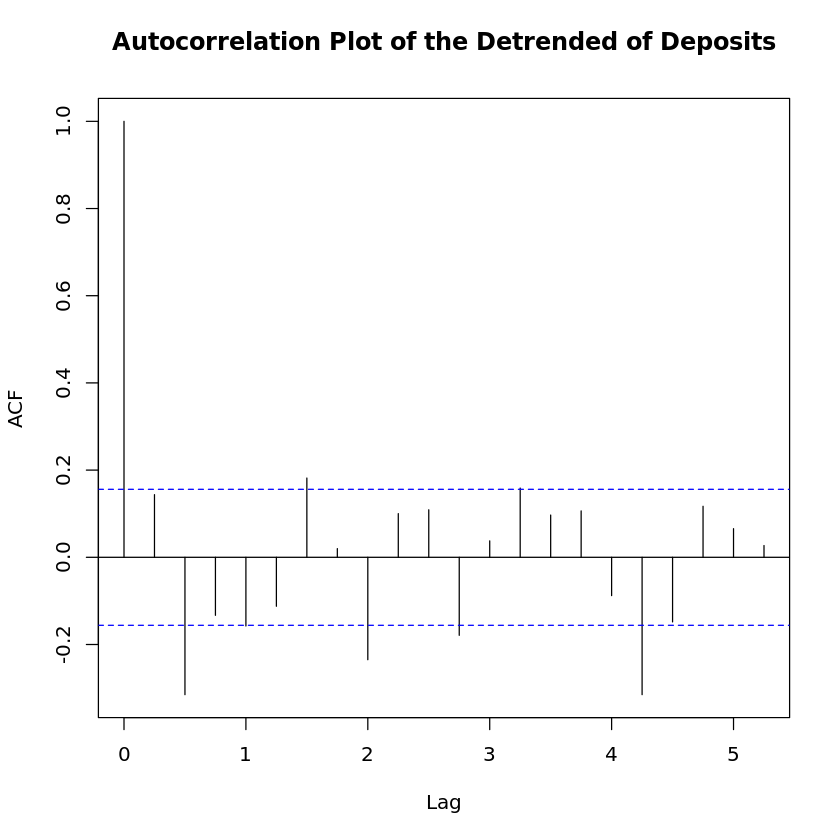

In [386]:
# Step 1: Convert deposits into a time series object. ACF only takes in time series data. 
deposit_time_series <- ts(deposit_levels$deposits, 
                        start = c(1984, 1), # we could have put deposit_levels$time_as_numeric but later on when plotting randomness the x axis won't show time properly so we just hardcode to tell where X axis will start and with frequency it knows how to link X and Y. 
                        frequency = 4) # Quarterly frequency 

# Step 2: Subtract the trend component, since the trend dominates, remove it to isolate the seasonality
        # Decompose the trend: breaks down the trend
deposit_decompose_trend <- decompose(deposit_time_series, type="additive") # breaks down dataset into 4 categories: observed data, trend, seasonality and randomness plot(deposit_decompose_trend) to see all 4 
        # Remove the trend from the time series data
deposit_detrended <- deposit_time_series - deposit_decompose_trend$trend

# Step 3: Plot ACF to check for seasonality
acf(deposit_detrended, na.action = na.omit, main = "Autocorrelation Plot of the Detrended of Deposits") # NAs comes from decomposition algorithm uses a moving window to calculate the trend, and it cannot compute values for the edges of the series.

#### b. Conclusion for Seasonality

- There are no peaks above the blue line at lag 4 (Quarterly Seasonality), the absence of such spikes suggests that quarterly seasonality is weak or not present in this case.

- For now, we will let Prophet's built-in seasonal detection handle any weak seasonal patterns

### Step 4: Outliers Expectation

**Why check for outliers**:  

- Prophet is designed to handle outliers and is fairly robust to their presence.

- However, extreme anomalies (like sudden, sharp increases or drops) can still affect the trend and seasonal components, distorting predictions.

In [387]:
# Check steps here: https://sqlpad.io/tutorial/interquartile-range/#:~:text=The%20standard%20method%20involves%20calculating,these%20bounds%20are%20potential%20outliers.

# Step 1: Calculate the IQR
IQR_value <- IQR(deposit_levels$deposits)

# Step 2: Define Boundaries
lower_bound <- quantile(deposit_levels$deposits, 0.25) - 1.5 * IQR_value
upper_bound <- quantile(deposit_levels$deposits, 0.75) + 1.5 * IQR_value

# Step 3: Flag Outliers
outliers <- subset(deposit_levels, deposits < lower_bound | deposits > upper_bound)

# step 4: Print Outliers
outliers

time,deposits,time_as_date,time_as_numeric,logistic_trend
<chr>,<dbl>,<date>,<dbl>,<dbl>



**Conclusion for Outliers:**

- Based of the results, it looks like the IQR method did not flag any outliers in the data. The deposit levels in the dataset fall within the acceptable range defined by the IQR method. The deposit levels may be naturally smooth without extreme spikes or dips (maybe lol?)

- Even without detected outliers, we should remain aware of contextual anomalies (e.g., the 2008 crisis) that could still affect model interpretation and trends.

### Step 5: Noise


**Why check for noise?**

- Noise refers to the unexplained or irrelevant variation in the data that cannot be attributed to meaningful patterns.
- Prophet is robust to noise, but excessive noise may require preprocessing (e.g., smoothing).
- A higher proportion (close to 1) indicates the data is dominated by noise.
- A lower proportion (closer to 0) means the data has more structured patterns (e.g., trend, seasonality).

In [388]:
# Calculate the variance of the residuals to quantify the noise and Compare this variance to the overall variance in the observed data.

# Variance of residuals (randomness)
residual_variance <- var(deposit_decompose_trend$random, na.rm = TRUE) # Use our decomposed dataset

# Variance of the original data
observed_variance <- var(deposit_time_series, na.rm = TRUE)  # Use our dataset that was transformed to time series, if we use deposit_levels directly it won't work

# Proportion of variance due to noise
global_noise_proportion <- residual_variance / observed_variance
global_noise_proportion

[1] 0.0006678225

**Conclusion for Noise**

- Our noise proportion of approximately 0.00067 (a very small number), which means: noise contributes very little to the overall variability in your data. 
- This is typical seen when our data has a strong long-term trend.
- So there won't be any need for excessive smoothing or denoising steps. Prophet can effectively handle the low-level noise.

#### Step 6: Localised Randomness

**Why check for randomness?**

-  Randomness, as shown in decomposition, includes localized irregularities or residual variations that aren't explained by the trend or seasonality but may include event-driven or one-off effects (like the 2008 crisis). It’s more localized and descriptive of specific periods rather than a global property like noise.
- While Prophet is robust to some noise, high randomness (localized irregularities) can make it harder to discern meaningful patterns.

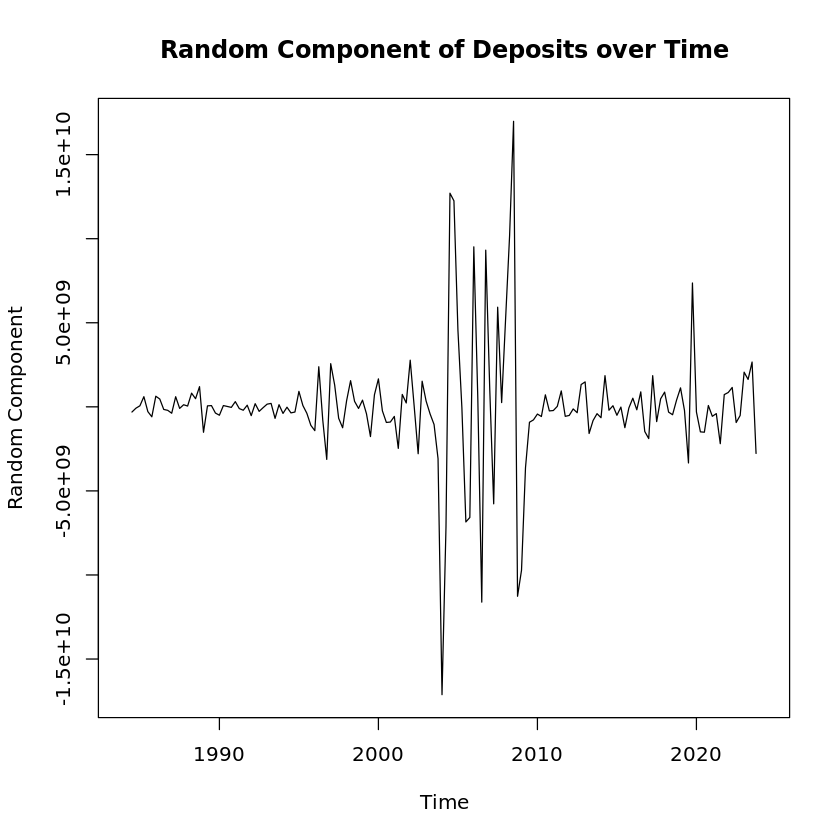

In [389]:
# plot(deposit_decompose_trend) ==> from the ACF code above in step 3.a

plot(deposit_decompose_trend$random,
    xlab = "Time",
    ylab = "Random Component",
    main = "Random Component of Deposits over Time")

**Conclusion for Randomness**
- There is significant randomness during the 2008 crisis period.
- We can add on a changepoint to handle abrupt trend changes.
- Prophet will automatically detects changepoints in the trend. However, you can manually specify changepoints (e.g., around 2008) where the data exhibits high variability.


## Part 3: Forecasting with Prophet

### Step 1: Split Data between training and test data

In [390]:
train_data <- deposit_levels[deposit_levels$time_as_date <= "2020-12-31", ]  # Training data: 1984 Q1 to 2020 Q4
test_data <- deposit_levels[deposit_levels$time_as_date > "2020-12-31", ]  # Testing data: 2021 Q1 to 2024 Q2

# Check
#View(train_data)
#View(test_data)


### Step 2: Prepared the Data

In [391]:
# Step 1: Prepare data for prophet to work

# you have to rename them as ds and y for prophet to work and it will automatically ignore all other columns ==> RULE
train_data$ds <- as.Date(train_data$time_as_date)
train_data$y <- train_data$deposits

test_data$ds <- as.Date(test_data$time_as_date)
test_data$y <- test_data$deposits

### Step 3: Fit Prophet on training data

In [392]:
# Step 1: Initialize the model
prophet_model<- prophet(changepoints = c("2008-01-01")) # Add Customizations based on assumptions made above https://stackoverflow.com/questions/64822488/how-to-use-prophets-make-future-dataframe-with-multiple-regressors
# We can later add on additional regressor to the best model

# Step 2: Fit the model: Training the model
prophet_model <- fit.prophet(prophet_model, train_data) # syntax


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Warning message in .local(object, ...):
“non-zero return code in optimizing”
Optimization terminated abnormally. Falling back to Newton optimizer.



### Step 4: Create a Future Dataframe

In [393]:
future_train_data <- make_future_dataframe(prophet_model, periods = 33, freq = "quarter") # start counting from the end of the training data: 2020 Q4 to 2028 Q1
#future_train_data # The output of make_future_dataframe() will include both the training data dates and the newly created future dates.

In [394]:
future_train_data

ds
<dttm>
1984-01-01
1984-04-01
1984-07-01
1984-10-01
1985-01-01
1985-04-01
1985-07-01
1985-10-01
1986-01-01


### Step 5: Predict Future Values

In [395]:
prediction_train_data <- predict(prophet_model, future_train_data)

In [396]:
prediction_train_data

ds,trend,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat_lower,yhat_upper,trend_lower,trend_upper,yhat
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1984-01-01,61881576748,-113084478129,-113084478129,-113084478129,-113084478129,-113084478129,-113084478129,0,0,0,-116651659842,19215573189,61881576748,61881576748,-51202901381
1984-04-01,64733317975,-110302906240,-110302906240,-110302906240,-110302906240,-110302906240,-110302906240,0,0,0,-111069460150,25931001679,64733317975,64733317975,-45569588265
1984-07-01,67585059201,-109580939640,-109580939640,-109580939640,-109580939640,-109580939640,-109580939640,0,0,0,-108886333677,27213875092,67585059201,67585059201,-41995880439
1984-10-01,70468138243,-113475956303,-113475956303,-113475956303,-113475956303,-113475956303,-113475956303,0,0,0,-114959010705,23631092588,70468138243,70468138243,-43007818059
1985-01-01,73351217285,-113647658322,-113647658322,-113647658322,-113647658322,-113647658322,-113647658322,0,0,0,-106837368490,21883288920,73351217285,73351217285,-40296441037
1985-04-01,76171620696,-112979125446,-112979125446,-112979125446,-112979125446,-112979125446,-112979125446,0,0,0,-100764602975,33410948570,76171620696,76171620696,-36807504751
1985-07-01,79023361922,-113276079940,-113276079940,-113276079940,-113276079940,-113276079940,-113276079940,0,0,0,-102701985354,30551140126,79023361922,79023361922,-34252718018
1985-10-01,81906440964,-114743706036,-114743706036,-114743706036,-114743706036,-114743706036,-114743706036,0,0,0,-101087827828,36644385234,81906440964,81906440964,-32837265072
1986-01-01,84789520006,-114053967918,-114053967918,-114053967918,-114053967918,-114053967918,-114053967918,0,0,0,-98636390787,38178320742,84789520006,84789520006,-29264447912


### Step 6: Visualize the Forecast

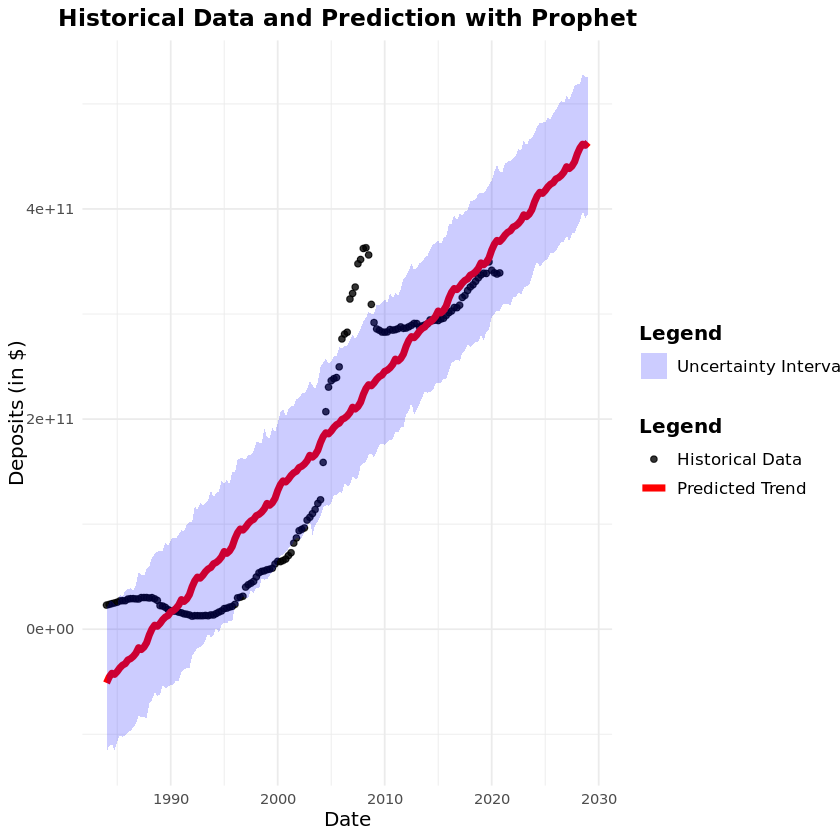

In [397]:
# Ensure 'ds' is a Date object
train_data$ds <- as.Date(train_data$ds)
prediction_train_data$ds <- as.Date(prediction_train_data$ds)

ggplot() +
  # Add historical data points
  geom_point(data = train_data, aes(x = ds, y = y, color = "Historical Data"), size = 1.5, alpha = 0.8) +
  # Add the predicted trend line
  geom_line(data = prediction_train_data, aes(x = ds, y = yhat, color = "Predicted Trend"), size = 2) +
  # Add uncertainty intervals for predictions
  geom_ribbon(
    data = prediction_train_data,
    aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Uncertainty Interval"),
    alpha = 0.2
  ) +
  # Add labels and a title
  labs(
    title = "Historical Data and Prediction with Prophet",
    x = "Date",
    y = "Deposits (in $)",
    color = "Legend",
    fill = "Legend"
  ) +
  # Customize colors for the legend
  scale_color_manual(
    values = c("Historical Data" = "black", "Predicted Trend" = "red")
  ) +
  scale_fill_manual(
    values = c("Uncertainty Interval" = "blue")
  ) +
  # Add a minimal theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10)
  )

## Part 4: Evaluation of the Model Performance

### Step 1: Compare predictions with test data 

- The test data is unseen data (not used in training) that allows you to assess how well your model generalizes to new data.
- Comparing predictions to actual values in the test data helps identify whether the model overfits or underfits.
- A good forecast should perform well not only on the training data but also on the test data. This is a crucial check before relying on the model for real-world forecasting.

In [398]:
#glimpse(test_data)

# Step 1: Create future dataframe for test data
future_test_data <- make_future_dataframe(prophet_model, periods = nrow(test_data), freq = "quarter") # Testing data: 2021 Q1 to 2024 Q2
#future_test_data

# Step 2: Make predictions for the test data
prediction_test_data <- predict(prophet_model, future_test_data) 
prediction_test_data$ds <- as.Date(prediction_test_data$ds) #make sure ds is in date format or else merge will fail

In [399]:
# Step 3: Merge predictions with actual test data: 
# The merging step combines your actual test data with the predictions generated by Prophet. This creates a single dataframe where you can directly compare the actual (y) and predicted (yhat) values for each time point (ds)
prediction_test_results <- merge(test_data, prediction_test_data[, c("ds", "yhat")], by = "ds")
prediction_test_results

#test_data
#prediction_test_data

ds,time,deposits,time_as_date,time_as_numeric,logistic_trend,y,yhat
<date>,<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01,2021Q1,339070926000,2021-01-01,18628,324359036936,339070926000,371764496914
2021-04-01,2021Q2,340991443000,2021-04-01,18718,324365839949,340991443000,375253433193
2021-07-01,2021Q3,342317919000,2021-07-01,18809,324371929301,342317919000,377808219919
2021-10-01,2021Q4,348156945000,2021-10-01,18901,324377371839,348156945000,379223672859
2022-01-01,2022Q1,351425943000,2022-01-01,18993,324382180069,351425943000,382796490012
2022-04-01,2022Q2,354666330000,2022-04-01,19083,324386341043,354666330000,383982465743
2022-07-01,2022Q3,355495449000,2022-07-01,19174,324390065459,355495449000,386106556777
2022-10-01,2022Q4,357699656000,2022-10-01,19266,324393394219,357699656000,389264027320
2023-01-01,2023Q1,361631019000,2023-01-01,19358,324396334988,361631019000,394422515288


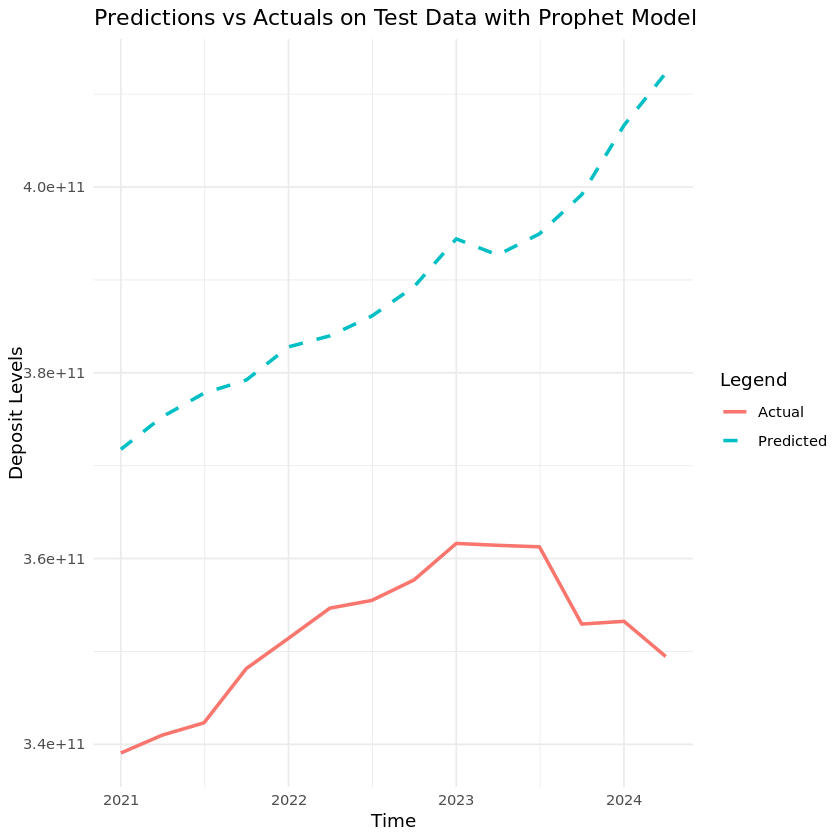

In [400]:
# Step 4: Plot the predictions vs actuals
ggplot(prediction_test_results, aes(x = ds)) +
  geom_line(aes(y = y, color = "Actual"), size = 1) + # Actual test data
  geom_line(aes(y = yhat, color = "Predicted"), size = 1, linetype = "dashed") + # Predictions
  labs(
    title = "Predictions vs Actuals on Test Data with Prophet Model",
    x = "Time",
    y = "Deposit Levels",
    color = "Legend"
  ) +
  theme_minimal()


**Observations**
- The predicted model (blue dashed line) done with Prophet does not closely align with the test (actual) data from 2021 to 2024. 
- There's a significant divergence between the actuals and predictions: the model overpredicts significantly in this range, showing an upward trend, whereas the actual values flatten or slightly decrease.

### Step 2. Compute Perfomance Metrics

- Necessary to be able to quantify the discrepancy between the actual data (test data) and the predicted data

In [401]:
# Mean Absolute Error (MAE)

actual <- prediction_test_results$y
predicted <- prediction_test_results$yhat

MAE_prophet <- mean(abs(actual - predicted))
MAE_prophet

# Root Mean Squared Error (RMSE)
RMSE_prophet <- sqrt(mean((actual - predicted)^2))
RMSE_prophet

# Mean Absolute Percentage Error (MAPE)
MAPE_prophet <- mean(abs(actual - predicted) / actual) * 100
MAPE_prophet

[1] 36897234426

[1] 38141270819

[1] 10.48863

- MAE = 36897, on average, our model's predictions are off by $36897 (Million) from the actual values.
- RMSE = 38141
- MAPE = 10%, on average our prediction are off by 10%. 

# Part 5: Adding on External Regressors to the Model

## Step 1: Select Relevant Features through domain knowledge

- Our goal here is research features that are likely to affect deposit level
- To narrow our options we will use a mix of domain knowledge and a LASSO regression to undertand the relationship between deposit and those potential regressors

> Here is a list of features through reserach and domain knowledge that I believe most impact deposit levels:
- GDP Growth Rate: Stronger economic growth can lead to higher income and savings
- Unemployment Rate: Higher unemployment can reduce deposits due to lower income
- Consumer Confidence Index: Reflects consumers' willingness to save vs. spend
- Population Growth: Larger populations in a region can increase deposit levels over time
- 10 Year Treasury Yield: Represent the interest rate environment, directly affecting deposit rates and competing as an alternative safe investment option.
- Federal Funds Effective Rate: impacts savings account interest rate
- Disposable Personal Income (percent change from year ago): ok
- Consumer Price Index (units: growth rate previos period in decimal): measure of inflation rate. Higher inflation may reduce disposable income and savings levels


## Step 2: Narrow Down Features through LASSO Regression

### A. Prepare the Data

- Combine deposit level data and regressors data into one => deposit_regressor_data
- Keeping the target variable (Deposit_Levels) untouched.
- Ensuring non-regressor columns (e.g., time) are excluded from scaling. time: A timestamp or date column (used for splitting but not for scaling or modeling).
- Scaling only the features (regressors). Other columns (GDP_Growth, Unemployment_Rate, Interest_Rate, SP500, etc.): Features to be scaled.

In [402]:
# Combine deposit level data and regressors data into one => deposit_regressor_data
deposit_regressor_data <- merge(deposit_levels, regressors_data, by = c("time_as_date", "time_as_numeric"))
deposit_regressor_data 

time_as_date,time_as_numeric,time,deposits,logistic_trend,population,unemployment_rate,ConsumerPriceIndex,DisposablePersonalIncome,Yield,fed_rate,GDP,GDP_growth_rate
<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1984-01-01,5113,1984Q1,22917257000,21838214,235604667,0.07866667,1.1202636,10729270000,0.11943333,0.09686667,3.908054e+12,NA
1984-04-01,5204,1984Q2,23575192000,24686425,236082333,0.07433333,1.0752688,11779660000,0.13200000,0.10556667,4.009601e+12,0.025984032
1984-07-01,5295,1984Q3,24308965000,27906077,236657333,0.07433333,1.0960671,10982020000,0.12866667,0.11390000,4.084250e+12,0.018617563
1984-10-01,5387,1984Q4,24967964000,31588126,237232667,0.07300000,0.7334184,9470080000,0.11743333,0.09266667,4.148551e+12,0.015743649
1985-01-01,5479,1985Q1,25673746000,35755947,237672667,0.07233333,0.6331117,7253910000,0.11583333,0.08476667,4.230168e+12,0.019673616
1985-04-01,5569,1985Q2,26941332000,40364715,238175667,0.07300000,1.2268009,7486790000,0.10813333,0.07923333,4.294887e+12,0.015299392
1985-07-01,5660,1985Q3,27141405000,45628873,238789333,0.07200000,0.7147296,5819840000,0.10336667,0.07900000,4.386773e+12,0.021394276
1985-10-01,5752,1985Q4,27133355000,51648972,239386667,0.07033333,0.8947856,6193650000,0.09760000,0.08103333,4.444094e+12,0.013066781
1986-01-01,5844,1986Q1,28651198000,58463197,239860667,0.07033333,0.2140673,7391500000,0.08556667,0.07826667,4.507894e+12,0.014356132


In [403]:
# Pre process only the regressors inside your data

# Exclude all that's not a regressor like the target varaiable (deposit) and time variables
regressors_col <- setdiff(names(deposit_regressor_data), c("logistic_trend", "time", "time_as_date", "time_as_numeric", "deposits"))

# The preProcess function centers (mean = 0) and scales (std = 1) your predictors => Apply scaling to the feature columns
pre_process_data <- preProcess(deposit_regressor_data[, regressors_col], method=c("center", "scale"))


## B. Split dataset into Training dataset and Test dataset

In [404]:
# Split data into training and testing based on time
train_data_regressor <- subset(deposit_regressor_data, time_as_date <= "2019-12-31") # Training data: 1984 Q1 to 2020 Q4
test_data_regressor <- subset(deposit_regressor_data, time_as_date > "2019-12-31")  # Testing data: 2021 Q1 to 2024 Q2


In [405]:
# Apply the pre-processing to our training and testing dataset

# Scale training data (apply preprocessing to the regressor columns only)
train_data_scaled <- train_data_regressor
train_data_scaled[, regressors_col] <- predict(pre_process_data, train_data_regressor[, regressors_col])

# Scale testing data using the same preprocessing parameters
test_data_scaled <- test_data_regressor
test_data_scaled[, regressors_col] <- predict(pre_process_data, test_data_regressor[, regressors_col])

In [406]:
#Check
train_data_scaled

,time_as_date,time_as_numeric,time,deposits,logistic_trend,population,unemployment_rate,ConsumerPriceIndex,DisposablePersonalIncome,Yield,fed_rate,GDP,GDP_growth_rate
,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1984-01-01,5113,1984Q1,22917257000,21838214,-1.723813,1.218313013,0.65970457,2.04629596,2.5907227,2.0758097,-1.374682,NA
2,1984-04-01,5204,1984Q2,23575192000,24686425,-1.708746,0.957802585,0.58896015,2.44325446,3.0606998,2.3721988,-1.359221,1.12682516
3,1984-07-01,5295,1984Q3,24308965000,27906077,-1.690610,0.957802585,0.62166082,2.14181406,2.9360374,2.6560963,-1.347855,0.50660191
4,1984-10-01,5387,1984Q4,24967964000,31588126,-1.672463,0.877645531,0.05147526,1.57042873,2.5159252,1.9327254,-1.338065,0.26463140
5,1985-01-01,5479,1985Q1,25673746000,35755947,-1.658584,0.837567003,-0.10623491,0.73290408,2.4560873,1.6635905,-1.325639,0.59551678
6,1985-04-01,5569,1985Q2,26941332000,40364715,-1.642719,0.877645531,0.82721110,0.82091301,2.1681172,1.4750825,-1.315785,0.22722697
7,1985-07-01,5660,1985Q3,27141405000,45628873,-1.623363,0.817527739,0.02209134,0.19094702,1.9898500,1.4671334,-1.301795,0.74038857
8,1985-10-01,5752,1985Q4,27133355000,51648972,-1.604522,0.717331421,0.30518980,0.33221556,1.7741841,1.5364044,-1.293068,0.03925119
9,1986-01-01,5844,1986Q1,28651198000,58463197,-1.589571,0.717331421,-0.76509047,0.78490146,1.3241530,1.4421504,-1.283354,0.14780873


In [407]:
regressors_col

[1] "population"               "unemployment_rate"       
[3] "ConsumerPriceIndex"       "DisposablePersonalIncome"
[5] "Yield"                    "fed_rate"                
[7] "GDP"                      "GDP_growth_rate"

### C. Fit the LASSO Model

In [408]:
# Create matrices for modeling for training data

X_train_lasso <- as.matrix(train_data_scaled[, regressors_col])
X_train_lasso[is.na(X_train_lasso)] <- 0 # fill the mssing value with 0
y_train_lasso <- train_data_scaled$deposits

# Create matrices for modeling for testing data
X_test_lasso <- as.matrix(test_data_scaled[, regressors_col])
y_test_lasso <- test_data_scaled$deposits


In [409]:
# Fit the lasso_model
lasso_model <- cv.glmnet(X_train_lasso, y_train_lasso, alpha = 1)
summary(lasso_model)

           Length Class  Mode     
lambda     77     -none- numeric  
cvm        77     -none- numeric  
cvsd       77     -none- numeric  
cvup       77     -none- numeric  
cvlo       77     -none- numeric  
nzero      77     -none- numeric  
call        4     -none- call     
name        1     -none- character
glmnet.fit 12     elnet  list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  
index       2     -none- numeric  

In [410]:
# Extract selected features at lambda.min
selected_features <- coef(lasso_model, s = "lambda.min")
print(selected_features)



9 x 1 sparse Matrix of class "dgCMatrix"
                                   s1
(Intercept)              193914862865
population                          .
unemployment_rate         31637026342
ConsumerPriceIndex         4136335856
DisposablePersonalIncome            .
Yield                               .
fed_rate                  32786591154
GDP                      194313307135
GDP_growth_rate          -10250663416


- You’ve chosen not to scale the deposits column, which is fine as long as you don’t intend to interpret the coefficients from the LASSO model directly. However, if coefficient interpretation is needed, it’s often better to scale the target variable as well (standardize deposits).
-  Lasso revealed that only unemployment rate and GDP are useful here.

In [411]:
# Rescale the coefficients to interpret them
rescaled_coef <- coef(lasso_model, s = "lambda.min")[-1] * pre_process_data$std
adjusted_intercept <- coef(lasso_model, s = "lambda.min")[1] - sum(rescaled_coef * pre_process_data$mean)
# Print the rescaled coefficients
print(rescaled_coef)


              population        unemployment_rate       ConsumerPriceIndex 
            0.000000e+00             5.262506e+08             2.630787e+09 
DisposablePersonalIncome                    Yield                 fed_rate 
            0.000000e+00             0.000000e+00             9.623951e+08 
                     GDP          GDP_growth_rate 
            1.276249e+24            -1.217484e+08 


### D. LINE Assaumptions

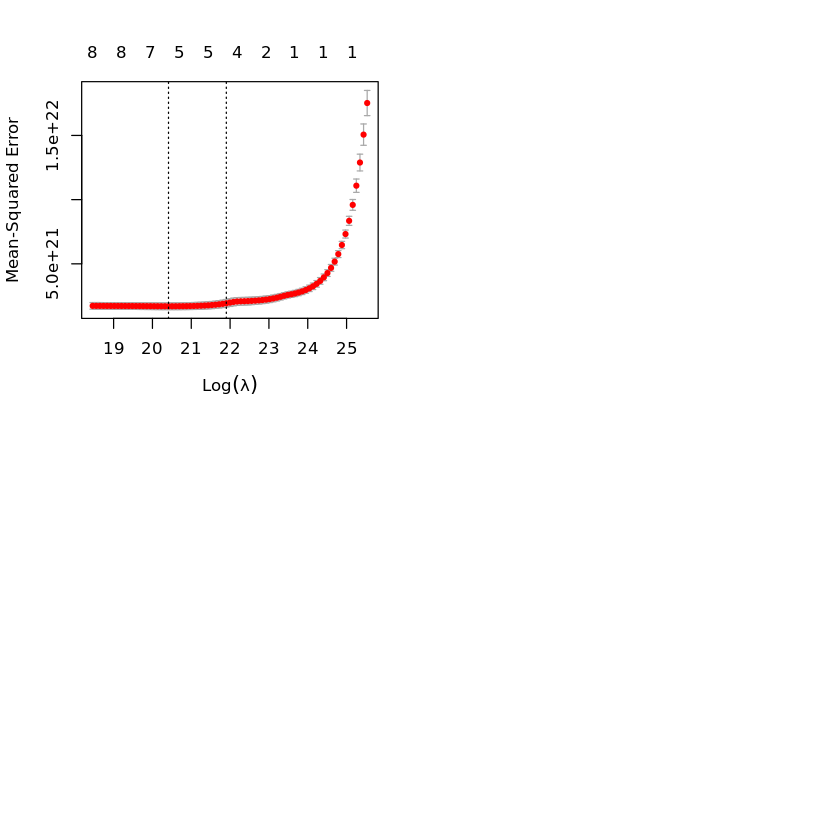

In [412]:
par(mfrow = c(2,2))
plot(lasso_model)

- I guess this is the only plot so we don't check for LINE aasumptins casuse Prophet is a semi-parametric model

### E. Performance Metrics

In [413]:
# Extract best lambda values
best_lambda <- lasso_model$lambda.min  # Lambda that gives minimum cross-validation error
best_lambda

[1] 733914775

In [414]:
# Predict on testing data
lasso_predictions <- predict(lasso_model, s = best_lambda, newx = X_test_lasso)

# Evaluate performance (e.g., Mean Squared Error)
MSE <- mean((y_test_lasso - lasso_predictions)^2)
print(MSE)

[1] NA


In [415]:

# Evaluate performance MAPE
MAPE <- mean(abs(y_test_lasso - lasso_predictions)/y_test_lasso)*100
print(MAPE)


[1] NA


- On average, the model's predictions are off by about 13% of the actual values. 

# Part 6: Add the regression into our model

## Step 1: Plugging Regressors into Prophet

- With a MAPE of 34%, it’s not ideal, but it’s not a dealbreaker
- Even if the Lasso model's MAPE is high, the regressors may still contain useful signals that Prophet can leverage.
- Prophet doesn't rely solely on the regressors—it also models time-based trends and seasonality, which can compensate for some of the inaccuracy in the regressors.

In [416]:
prophet_data_2 <- data.frame(
    ds = deposit_regressor_data$time_as_date,
    y = deposit_regressor_data$deposits,
    GDP = deposit_regressor_data$GDP,
    unemployment_rate = deposit_regressor_data$unemployment_rate,
    fed_rate = deposit_regressor_data$fed_rate,
    ConsumerPriceIndex = deposit_regressor_data$ConsumerPriceIndex
    
)
#prophet_data_2

In [417]:

# Step 1: Split Data between training and test data
train_data_2 <- subset(prophet_data_2, ds <= "2019-12-31") # Training data: 1984 Q1 to 2020 Q4
test_data_2 <- subset(prophet_data_2, ds > "2019-12-31")  # Testing data: 2021 Q1 to 2024 Q2

# Step 1: Prepare data for prophet to work

# you have to rename them as ds and y for prophet to work and it will automatically ignore all other columns ==> RULE
train_data_2$ds <- as.Date(train_data_2$ds)
train_data_2$y <- train_data_2$y

test_data_2$ds <- as.Date(test_data_2$ds)
test_data_2$y <- test_data_2$y


# Check
tail(train_data_2)
View(test_data_2)

,ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139,2018-07-01,331039546000,2.079873e+13,0.03766667,0.01923333,0.32726757
140,2018-10-01,334393555000,2.091787e+13,0.03833333,0.02220000,-0.05749474
141,2019-01-01,337239215000,2.111160e+13,0.03866667,0.02403333,0.33511603
142,2019-04-01,338841270000,2.139794e+13,0.03633333,0.02396667,1.19851323
143,2019-07-01,338626199000,2.171717e+13,0.03600000,0.02190000,0.27416601
144,2019-10-01,349600055000,2.193322e+13,0.03600000,0.01643333,0.21301800


,ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
145,2020-01-01,341691380000,2.172766e+13,0.03833333,0.0126000000,0.4194274
146,2020-04-01,339227043000,1.993544e+13,0.13000000,0.0006000000,-0.5400354
147,2020-07-01,338020161000,2.168455e+13,0.08800000,0.0009333333,1.1314854
148,2020-10-01,339166813000,2.206877e+13,0.06733333,0.0009000000,0.2299503
149,2021-01-01,339070926000,2.265679e+13,0.06233333,0.0008000000,1.0731144
150,2021-04-01,340991443000,2.336886e+13,0.05933333,0.0007000000,2.3397887
151,2021-07-01,342317919000,2.392199e+13,0.05066667,0.0009000000,1.6009753
152,2021-10-01,348156945000,2.477704e+13,0.04166667,0.0008000000,1.5177614
153,2022-01-01,351425943000,2.521549e+13,0.03800000,0.0012000000,2.2834645


In [418]:
# Step 3: Initialize the model by adding on regressors and Fit Prophet

# Initialize the model
prophet_model_2 <- prophet()

# Add regressors
prophet_model_2 <- add_regressor(prophet_model_2, 'GDP')
prophet_model_2 <- add_regressor(prophet_model_2, 'unemployment_rate')
prophet_model_2 <- add_regressor(prophet_model_2, 'ConsumerPriceIndex')
prophet_model_2 <- add_regressor(prophet_model_2, 'fed_rate')

# Step 2: Fit the model: Training the model
prophet_model_2 <- fit.prophet(prophet_model_2, train_data_2) # syntax


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [419]:
# Step 4: Create a future dataframe
future_train_data_2 <- make_future_dataframe(prophet_model_2, periods = 33, freq = "quarter") # start counting from the end of the training data: 2020 Q4 to 2028 Q1
future_train_data_2 # The output of make_future_dataframe() will include both the training data dates and the newly created future dates.future_train_data_2

ds
<dttm>
1984-01-01
1984-04-01
1984-07-01
1984-10-01
1985-01-01
1985-04-01
1985-07-01
1985-10-01
1986-01-01


In [420]:
# Step 1: Create dataframes for GDP and unemployment rate
gdp_data <- data.frame(
  ds = train_data_2$ds, # Use the same date column as in your training data
  y = train_data_2$GDP  # Use the GDP column
)

unemployment_data <- data.frame(
  ds = train_data_2$ds, # Use the same date column as in your training data
  y = train_data_2$unemployment_rate # Use the unemployment rate column
)

fed_data <- data.frame(
  ds = train_data_2$ds, # Use the same date column as in your training data
  y = train_data_2$fed_rate # Use the fed rate column
)

CPI_data <- data.frame(
  ds = train_data_2$ds, # Use the same date column as in your training data
  y = train_data_2$ConsumerPriceIndex # Use the CPI column
) 

# Step 2: Fit Prophet models for GDP and unemployment rate
gdp_model <- prophet(gdp_data) # Fit the GDP model
unemployment_model <- prophet(unemployment_data) # Fit the unemployment rate model
fed_model <- prophet(fed_data)
CPI_model <- prophet(CPI_data)

# Step 3: Generate future dataframes matching the number of rows in future_train_data_2
future_gdp <- make_future_dataframe(gdp_model, periods = nrow(future_train_data_2) - nrow(train_data_2), freq = "quarter")
future_unemployment <- make_future_dataframe(unemployment_model, periods = nrow(future_train_data_2) - nrow(train_data_2), freq = "quarter")
future_fed <- make_future_dataframe(fed_model, periods = nrow(future_train_data_2) - nrow(train_data_2), freq = "quarter")
future_CPI <- make_future_dataframe(CPI_model, periods = nrow(future_train_data_2) - nrow(train_data_2), freq = "quarter")

# Step 4: Forecast the future regressor values
gdp_forecast <- predict(gdp_model, future_gdp)
unemployment_forecast <- predict(unemployment_model, future_unemployment)
fed_forecast <- predict(fed_model, future_fed)
CPI_forcast <- predict(CPI_model, future_CPI)

# Step 5: Extract forecasted values for GDP and unemployment rate
future_GDP_values <- gdp_forecast$yhat[(nrow(train_data_2) + 1):nrow(future_gdp)]
future_unemployment_values <- unemployment_forecast$yhat[(nrow(train_data_2) + 1):nrow(future_unemployment)]
future_fed_rate_values <- fed_forecast$yhat[(nrow(train_data_2) + 1):nrow(future_fed)]
future_CPI_values <- CPI_forcast$yhat[(nrow(train_data_2) + 1):nrow(future_CPI)]

# Step 6: Add future GDP and unemployment rate values to future_train_data_2
future_train_data_2$GDP <- c(train_data_2$GDP, future_GDP_values) # Combine training and future GDP values
future_train_data_2$unemployment_rate <- c(train_data_2$unemployment_rate, future_unemployment_values) # Combine training and future unemployment rate values
future_train_data_2$fed_rate <- c(train_data_2$fed_rate, future_fed_rate_values) # Combine training and future GDP values
future_train_data_2$ConsumerPriceIndex <- c(train_data_2$ConsumerPriceIndex, future_CPI_values) # Combine training and future GDP values

# Step 7: Verify the updated future_train_data_2
View(future_train_data_2) # Check the final dataframe with added columns


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



ds,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
1984-01-01,3.908054e+12,0.07866667,0.09686667,1.1202636
1984-04-01,4.009601e+12,0.07433333,0.10556667,1.0752688
1984-07-01,4.084250e+12,0.07433333,0.11390000,1.0960671
1984-10-01,4.148551e+12,0.07300000,0.09266667,0.7334184
1985-01-01,4.230168e+12,0.07233333,0.08476667,0.6331117
1985-04-01,4.294887e+12,0.07300000,0.07923333,1.2268009
1985-07-01,4.386773e+12,0.07200000,0.07900000,0.7147296
1985-10-01,4.444094e+12,0.07033333,0.08103333,0.8947856
1986-01-01,4.507894e+12,0.07033333,0.07826667,0.2140673


In [421]:
# Step 6: Predict Future Values
prediction_train_data_2 <- predict(prophet_model_2, future_train_data_2)

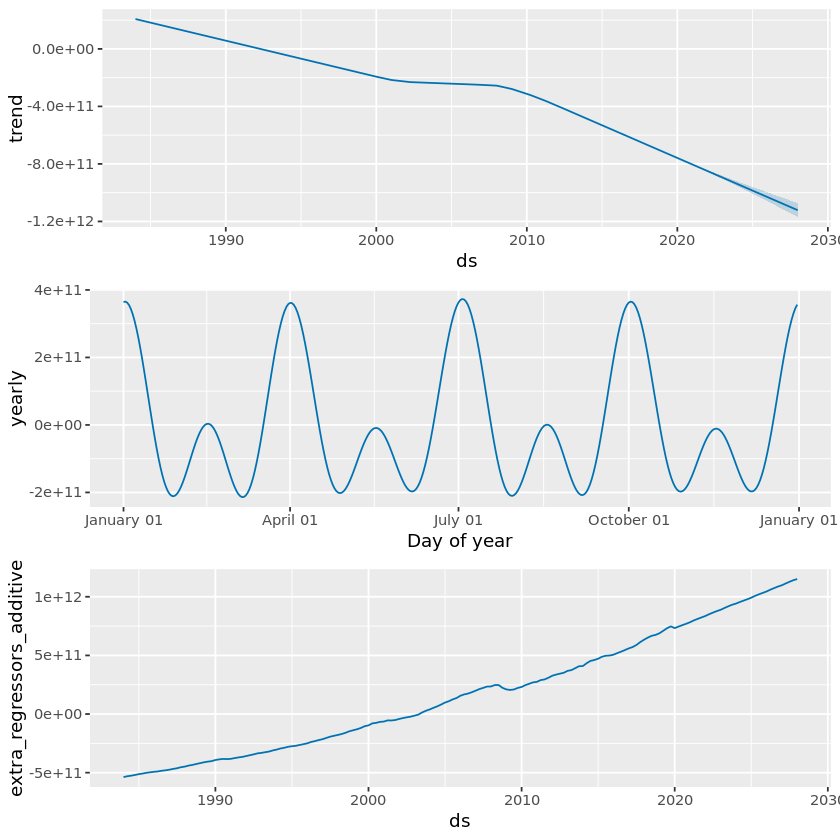

In [422]:
prophet_plot_components(prophet_model_2, prediction_train_data_2)

## Step 2: Visualize the foreacast

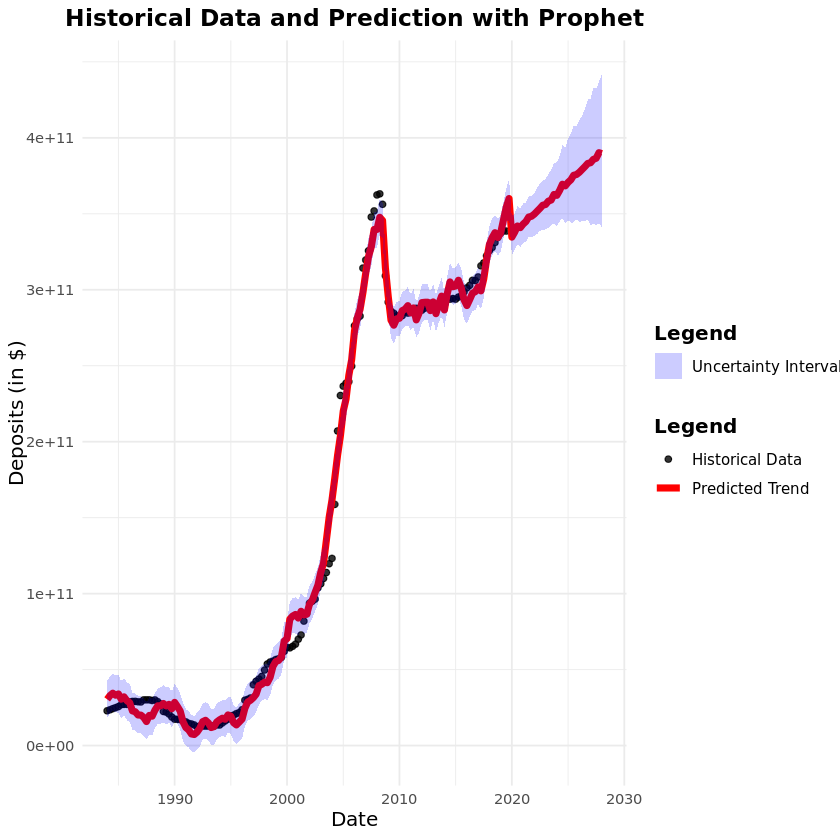

In [423]:
# Ensure 'ds' is a Date object
train_data_2$ds <- as.Date(train_data_2$ds)
prediction_train_data_2$ds <- as.Date(prediction_train_data_2$ds)

ggplot() +
  # Add historical data points
  geom_point(data = train_data_2, aes(x = ds, y = y, color = "Historical Data"), size = 1.5, alpha = 0.8) +
  # Add the predicted trend line
  geom_line(data = prediction_train_data_2, aes(x = ds, y = yhat, color = "Predicted Trend"), size = 2) +
  # Add uncertainty intervals for predictions
  geom_ribbon(
    data = prediction_train_data_2,
    aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Uncertainty Interval"),
    alpha = 0.2
  ) +
  # Add labels and a title
  labs(
    title = "Historical Data and Prediction with Prophet",
    x = "Date",
    y = "Deposits (in $)",
    color = "Legend",
    fill = "Legend"
  ) +
  # Customize colors for the legend
  scale_color_manual(
    values = c("Historical Data" = "black", "Predicted Trend" = "red")
  ) +
  scale_fill_manual(
    values = c("Uncertainty Interval" = "blue")
  ) +
  # Add a minimal theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 9)
  )

## Step 3: Evaluation of the Model Performance

You don't need to use make_future_dataframe() again for the test data if you already have test_data_2. The test data already contains the actual dates and regressors needed for evaluation.

In [424]:
View(test_data_2)

,ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
145,2020-01-01,341691380000,2.172766e+13,0.03833333,0.0126000000,0.4194274
146,2020-04-01,339227043000,1.993544e+13,0.13000000,0.0006000000,-0.5400354
147,2020-07-01,338020161000,2.168455e+13,0.08800000,0.0009333333,1.1314854
148,2020-10-01,339166813000,2.206877e+13,0.06733333,0.0009000000,0.2299503
149,2021-01-01,339070926000,2.265679e+13,0.06233333,0.0008000000,1.0731144
150,2021-04-01,340991443000,2.336886e+13,0.05933333,0.0007000000,2.3397887
151,2021-07-01,342317919000,2.392199e+13,0.05066667,0.0009000000,1.6009753
152,2021-10-01,348156945000,2.477704e+13,0.04166667,0.0008000000,1.5177614
153,2022-01-01,351425943000,2.521549e+13,0.03800000,0.0012000000,2.2834645


In [425]:
#colnames(prediction_test_results_2)
glimpse(train_data_2)

Rows: 144
Columns: 6
$ ds                 <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-01, 19…
$ y                  <dbl> 22917257000, 23575192000, 24308965000, 24967964000,…
$ GDP                <dbl> 3.908054e+12, 4.009601e+12, 4.084250e+12, 4.148551e…
$ unemployment_rate  <dbl> 0.07866667, 0.07433333, 0.07433333, 0.07300000, 0.0…
$ fed_rate           <dbl> 0.09686667, 0.10556667, 0.11390000, 0.09266667, 0.0…
$ ConsumerPriceIndex <dbl> 1.1202636, 1.0752688, 1.0960671, 0.7334184, 0.63311…


In [426]:
# Train models for GDP and unemployment rate, CPI and fed rate
gdp_model_2 <- prophet(data.frame(ds = train_data_2$ds, y = train_data_2$GDP))
unemployment_model_2 <- prophet(data.frame(ds = train_data_2$ds, y = train_data_2$unemployment_rate))
fed_model_2 <- prophet(data.frame(ds = train_data_2$ds, y = train_data_2$fed_rate))
CPI_model_2 <- prophet(data.frame(ds = train_data_2$ds, y = train_data_2$ConsumerPriceIndex))

# Create future dataframes for GDP and unemployment rate
future_gdp_2 <- make_future_dataframe(gdp_model_2, periods = nrow(test_data_2), freq = "quarter")
future_unemployment_2 <- make_future_dataframe(unemployment_model_2, periods = nrow(test_data_2), freq = "quarter")
future_fed_2 <- make_future_dataframe(fed_model_2, periods = nrow(test_data_2), freq = "quarter")
future_CPI_2 <- make_future_dataframe(CPI_model_2, periods = nrow(test_data_2), freq = "quarter")

# Predict future values for GDP and unemployment rate
gdp_forecast_2 <- predict(gdp_model_2, future_gdp_2)
unemployment_forecast_2 <- predict(unemployment_model_2, future_unemployment_2)
fed_forecast_2 <- predict(fed_model_2, future_fed_2)
CPI_forcast_2 <- predict(CPI_model_2, future_CPI_2)

# Create future dataframe for test data
future_test_data_2 <- make_future_dataframe(prophet_model_2, periods = nrow(test_data_2), freq = "quarter") # Testing data: 2021 Q1 to 2024 Q2
#future_test_data_2

# Extract predicted values for GDP and unemployment rate
future_test_data_2$GDP <- gdp_forecast_2$yhat
future_test_data_2$unemployment_rate <- unemployment_forecast_2$yhat
future_test_data_2$fed_rate <- fed_forecast_2$yhat
future_test_data_2$ConsumerPriceIndex <- CPI_forcast_2$yhat


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [427]:
prediction_test_data_2 <- predict(prophet_model_2, future_test_data_2)


In [428]:
# Step 3: Merge predictions with actual test data: 

prediction_test_data_2$ds <- as.Date(prediction_test_data_2$ds) #make sure ds is in date format or else merge will fail

# The merging step combines your actual test data with the predictions generated by Prophet. This creates a single dataframe where you can directly compare the actual (y) and predicted (yhat) values for each time point (ds)
prediction_test_results_2 <- merge(test_data_2, prediction_test_data_2[, c("ds", "yhat")], by = "ds")
prediction_test_results_2

ds,y,GDP,unemployment_rate,fed_rate,ConsumerPriceIndex,yhat
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-01,341691380000,2.172766e+13,0.03833333,0.0126000000,0.4194274,334651343674
2020-04-01,339227043000,1.993544e+13,0.13000000,0.0006000000,-0.5400354,337896118999
2020-07-01,338020161000,2.168455e+13,0.08800000,0.0009333333,1.1314854,341959820109
2020-10-01,339166813000,2.206877e+13,0.06733333,0.0009000000,0.2299503,340882212336
2021-01-01,339070926000,2.265679e+13,0.06233333,0.0008000000,1.0731144,343210137836
2021-04-01,340991443000,2.336886e+13,0.05933333,0.0007000000,2.3397887,344881467019
2021-07-01,342317919000,2.392199e+13,0.05066667,0.0009000000,1.6009753,347857595703
2021-10-01,348156945000,2.477704e+13,0.04166667,0.0008000000,1.5177614,348352714978
2022-01-01,351425943000,2.521549e+13,0.03800000,0.0012000000,2.2834645,349804656687


In [429]:
# Mean Absolute Error (MAE)

actual_2 <- prediction_test_results_2$y
predicted_2 <- prediction_test_results_2$yhat

MAE_prophet_2 <- mean(abs(actual_2 - predicted_2))
MAE_prophet_2

# Root Mean Squared Error (RMSE)
RMSE_prophet2 <- sqrt(mean((actual_2 - predicted_2)^2))
RMSE_prophet2

# Mean Absolute Percentage Error (MAPE)
MAPE_prophet2 <- mean(abs(actual_2 - predicted_2) / actual_2) * 100
MAPE_prophet2

# 

[1] 4547090244

[1] 5896065832

[1] 1.301795

In [430]:
# Assuming you have these variables in your data:
# train_data_2 is the training dataset
# test_data_2 is the testing dataset
# prediction_test_results_2 contains the predicted values for the test set

# Define the MASE calculation function
mase <- function(y_train, y_test, y_preds) {
  # Calculate the naive errors for the training data
  naive_errors <- abs(diff(y_train))  # Absolute differences between consecutive training values
  denom <- mean(naive_errors)        # Mean absolute naive error
  
  # Calculate the forecast errors for the test data
  num <- mean(abs(y_test - y_preds)) # Mean absolute forecast error
  
  # Return MASE
  return(num / denom)
}

# Use the actual training and test values
y_train <- train_data_2$y  # Replace with the actual column name for the dependent variable in your training set
y_test <- test_data_2$y    # Replace with the actual column name for the dependent variable in your test set
y_preds <- prediction_test_results_2$yhat  # Replace with the column containing predictions in your results

# Calculate MASE
mase_result <- mase(y_train, y_test, y_preds)

# Print the result
print(paste("MASE:", mase_result))


[1] "MASE: 1.20487106026656"


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


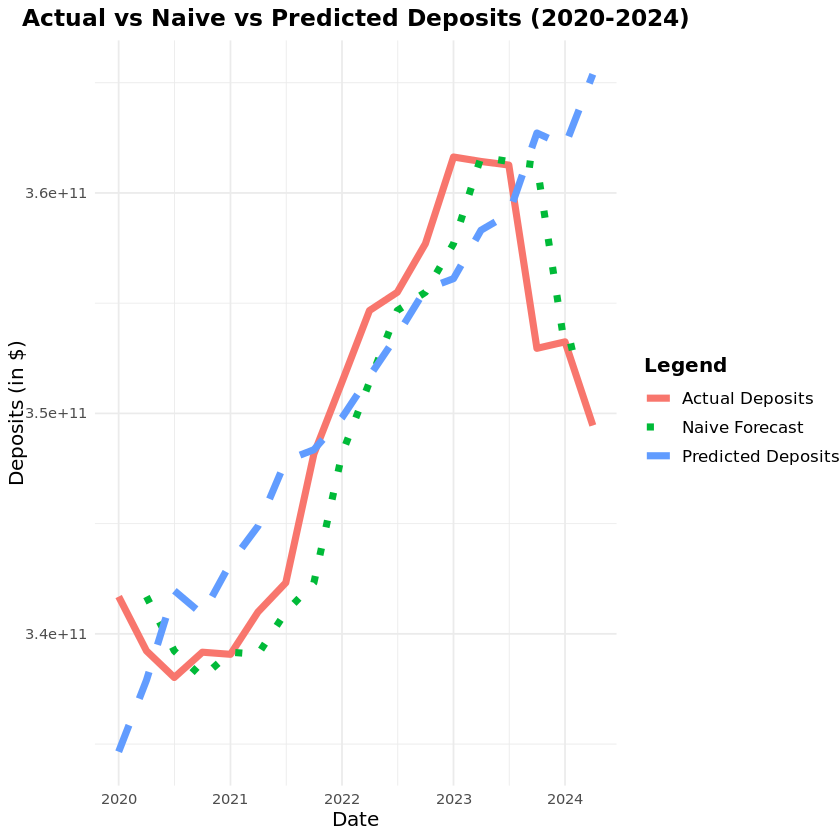

In [434]:
# Calculate naive forecast
naive_forecast <- c(NA, head(test_data_2$y, -1))  # Shift y_test by one step for naive forecast

# Create a data frame for plotting
naive_vs_model <- data.frame(
  Date = test_data_2$ds,  # Dates from test data
  Actual_Deposits = test_data_2$y,  # Actual deposit values
  Naive_Forecast = naive_forecast,  # Naive forecast values
  Predicted_Deposits = prediction_test_results_2$yhat  # Predicted deposit values
)

# Plot the data
library(ggplot2)
ggplot(naive_vs_model, aes(x = Date)) +
  geom_line(aes(y = Actual_Deposits, color = "Actual Deposits"), size = 2) +  # Line for actual deposits
  geom_line(aes(y = Naive_Forecast, color = "Naive Forecast"), size = 2, linetype = "dotted") +  # Dotted line for naive forecast
  geom_line(aes(y = Predicted_Deposits, color = "Predicted Deposits"), size = 2, linetype = "dashed") +  # Dashed line for model predictions
  labs(
    title = "Actual vs Naive vs Predicted Deposits (2020-2024)",
    x = "Date",
    y = "Deposits (in $)",
    color = "Legend"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10)
  )


